In [8]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
import time

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
X = df.drop('target', axis=1)
y = df['target']

In [11]:
std = StandardScaler()
X_std = std.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# **Class Simulated Annealing**

In [13]:
#--------------------------------------------------------------------------------------
# Initialize the Simulated Annealing optimizer class
#--------------------------------------------------------------------------------------
class SimulatedAnnealing:
    def __init__(self, X_train, y_train, initial_temperature=100, cooling_rate=0.99,iterations=1000, step_size=0.1, penalty = "no", lambda_term=0.01):
        #Initialize parameters
        self.X_train = X_train
        self.y_train = y_train
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.iterations = iterations
        self.step_size = step_size
        self.best_weights = None
        self.penalty = penalty
        self.lambda_term = lambda_term  

    #--------------------------------------------------------------------------------------
    # Sigmoid function for logistic regression 
    #--------------------------------------------------------------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    #--------------------------------------------------------------------------------------
    # Cross entropy loss function (to be minimized)
    #--------------------------------------------------------------------------------------
    def cross_entropy_loss(self, beta):
        z = np.dot(self.X_train, beta)
        p = self.sigmoid(z)
        epsilon = 1e-15  # To avoid log(0)
        loss = -np.mean(self.y_train * np.log(p + epsilon) + (1 - self.y_train) * np.log(1 - p + epsilon))
        
        # Add regularization penalty if specified
        if self.penalty.lower() == 'l1':
            reg = self.lambda_term * np.sum(np.abs(beta))
        elif self.penalty.lower() == 'l2':
            reg = self.lambda_term * np.sum(beta ** 2)
        else:
            reg = 0
        # Return the negative loss (because we want to maximize fitness)
        return (loss) + reg

    #--------------------------------------------------------------------------------------
    # Main optimization function that runs simulated annealing
    #--------------------------------------------------------------------------------------
    def optimize(self):
        # 1. Initialize weights randomly between -1 and 1
        current_weights = np.random.uniform(-1, 1, self.X_train.shape[1])
        current_loss = self.cross_entropy_loss(current_weights)
        
        # Keep track of the best solution found
        best_weights = current_weights.copy()
        best_loss = current_loss
        loss_history = [best_loss]
        temperature = self.initial_temperature

        # 2. Iteratively search for a better solution
        for iteration in range(self.iterations):
            # Generate a candidate solution by perturbing the current weights
            candidate_weights = current_weights + np.random.normal(0, self.step_size, self.X_train.shape[1])
            candidate_loss = self.cross_entropy_loss(candidate_weights)

            # Calculate the change in loss (energy)
            delta = candidate_loss - current_loss

            # 3. Decide whether to accept the candidate solution
            if delta < 0 or np.random.rand() < np.exp(-delta / temperature):
                current_weights = candidate_weights.copy()
                current_loss = candidate_loss

                # Update the best solution if the candidate is better
                if current_loss < best_loss:
                    best_weights = current_weights.copy()
                    best_loss = current_loss

            # Cool down the temperature
            temperature *= self.cooling_rate
            loss_history.append(best_loss)

            # Optionally print progress every 1000 iterations
            if (iteration + 1) % 1000 == 0:
                print(f"Iteration {iteration + 1}: Best Loss = {best_loss:.4f}")

        self.best_weights = best_weights
        print(f"Best Weights: \n{self.best_weights}")
        print(f"\nBest Loss: {best_loss:.4f}")
        return best_weights, loss_history

    #--------------------------------------------------------------------------------------
    # Predict the target variable for new data using the optimized weights
    #--------------------------------------------------------------------------------------
    def predict_proba(self, X):
        z = np.dot(X, self.best_weights)
        return self.sigmoid(z)

    def predict(self, X, threshold=0.45):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

    #--------------------------------------------------------------------------------------
    # Evaluate the model using various metrics
    #--------------------------------------------------------------------------------------
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        print("\nEvaluation Metrics:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

    #--------------------------------------------------------------------------------------
    # Plot the loss evolution over iterations
    #--------------------------------------------------------------------------------------
    def plot_loss(self, loss_history):
        plt.figure(figsize=(6, 4))
        plt.plot(loss_history, label='Best Loss')
        plt.title("Loss Evolution Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Cross Entropy Loss")
        plt.grid(True)
        plt.legend()
        plt.show()

**Simulated Annealing without penalty**

Iteration 1000: Best Loss = 0.1249
Best Weights: 
[-2.34723582 -1.2351713  -2.51319953  2.64319093  1.40172189  1.17119375
 -2.73506997 -0.16316966  1.29276272  0.34574804 -2.5759092  -0.9706431
 -2.77737146 -2.37237228 -2.13601696  1.17320044 -0.878201    1.65165003
  1.63579651  2.40648361  1.00643064  0.24540128  0.36652496 -1.31611481
 -1.49818457 -2.9833517  -1.73093384 -1.86083598 -1.62269188 -0.18928798]

Best Loss: 0.1249

Evaluation Metrics:
Accuracy:  0.9474
F1 Score:  0.9571
Precision: 0.9710
Recall:    0.9437
ROC AUC:   0.9486


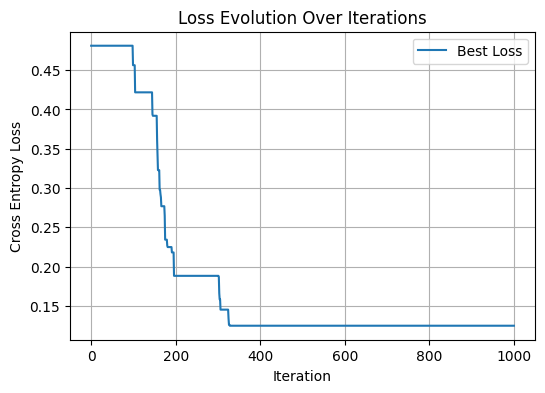

In [14]:
sa = SimulatedAnnealing(X_train, y_train, initial_temperature=100, cooling_rate=0.99,iterations=1000, step_size=0.1, penalty = "no", lambda_term=0.01)
best_weights, loss_history = sa.optimize()
sa.predict(X_test)
sa.evaluate(X_test, y_test)
sa.plot_loss(loss_history)

**Regularization**

L1 Regularization

Iteration 1000: Best Loss = 0.5057
Best Weights: 
[-0.26750284  0.18945511 -0.51089259 -0.05261399 -0.90947335 -0.48245473
 -1.10879972  0.26987481  0.48582358  0.89978056 -0.25943039 -0.46681598
 -0.10595921 -4.45305301 -1.41080543 -1.98245323  2.03667487  0.94569087
  1.19845199  0.71906107 -1.8869406  -3.20551442  0.58867978 -2.2899167
 -1.39943245 -1.20984165 -4.69258789  0.85820821 -2.24123221  2.6703602 ]

Best Loss: 0.5057

Evaluation Metrics:
Accuracy:  0.9561
F1 Score:  0.9645
Precision: 0.9714
Recall:    0.9577
ROC AUC:   0.9556


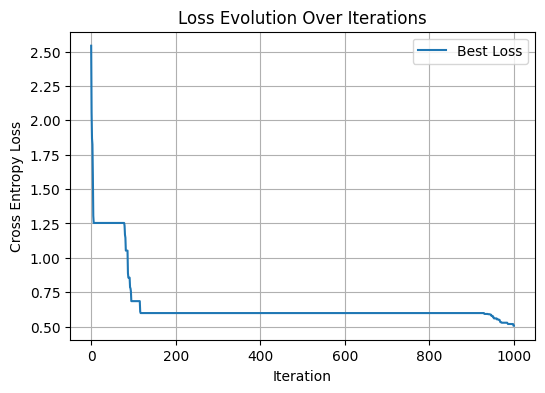

In [15]:
sa = SimulatedAnnealing(X_train, y_train, initial_temperature=100, cooling_rate=0.99,iterations=1000, step_size=0.1, penalty = "L1", lambda_term=0.01)
best_weights, loss_history = sa.optimize()
sa.predict(X_test)
sa.evaluate(X_test, y_test)
sa.plot_loss(loss_history)

L2 Regularization

Iteration 1000: Best Loss = 1.0487
Best Weights: 
[-1.84958601 -1.42041263  0.4665533   1.22022752  1.63093214 -0.53354612
  0.75550167 -4.43750235 -0.17685672 -1.44009126  1.97377119  0.00630064
 -0.32488019 -1.70590842  1.82229369  3.37309881  0.33203019 -0.45005104
 -1.91050805 -0.65766064 -3.3561738  -1.12567109 -0.65448083 -1.98888788
 -1.3707277  -0.20350218 -1.32469348 -2.52814097  1.28077954  0.51030597]

Best Loss: 1.0487

Evaluation Metrics:
Accuracy:  0.9474
F1 Score:  0.9571
Precision: 0.9710
Recall:    0.9437
ROC AUC:   0.9486


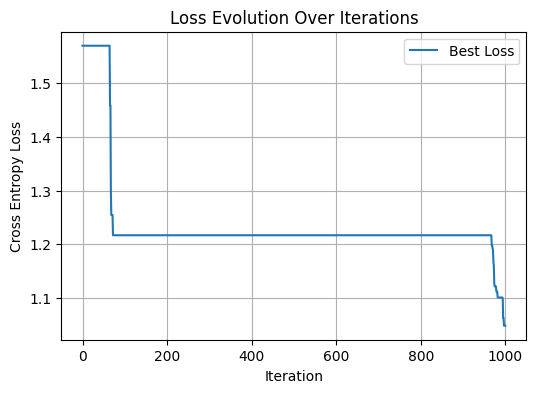

In [16]:
sa = SimulatedAnnealing(X_train, y_train, initial_temperature=100, cooling_rate=0.99,iterations=1000, step_size=0.1, penalty = "L2", lambda_term=0.01)
best_weights, loss_history = sa.optimize()
sa.predict(X_test)
sa.evaluate(X_test, y_test)
sa.plot_loss(loss_history)

**Hyperparameter Tuning**

No Regularization

Iteration 1000: Best Loss = 0.0407
Best Weights: 
[-1.41723399 -0.0747818  -1.01926513 -1.47886741 -0.20083771  2.98265149
 -1.47264131 -1.98975897  0.99615702 -1.19355624 -3.09613435  0.59525724
 -0.50369386 -2.33496609 -0.33708677  1.40299706  1.58535781 -1.91699177
  0.75530018  0.89491511 -1.08643521 -2.81502353 -0.52622517  0.48000799
 -0.81304485 -0.196989   -2.82356065 -0.4915244  -2.52212778 -0.07889452]

Best Loss: 0.0407

Evaluation Metrics:
Accuracy:  0.9649
F1 Score:  0.9718
Precision: 0.9718
Recall:    0.9718
ROC AUC:   0.9627


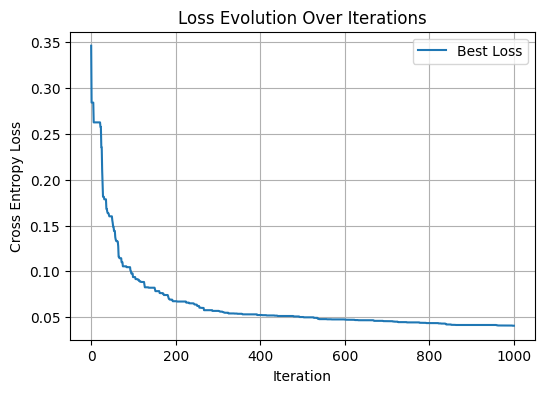

In [17]:
sa1 = SimulatedAnnealing(X_train, y_train, initial_temperature=200, cooling_rate=0.49,iterations=1000, step_size=0.1, penalty = "no", lambda_term=0.01)
best_weights, loss_history = sa1.optimize()
sa1.predict(X_test)
sa1.evaluate(X_test, y_test)
sa1.plot_loss(loss_history)

Iteration 1000: Best Loss = 0.1802
Best Weights: 
[-7.98994240e-01  1.44580348e-02  7.71938994e-03 -4.38376839e-02
 -2.74996210e-02  6.41362222e-02 -3.85045431e-01 -2.13076030e-01
 -4.34094970e-02  8.44208291e-02 -1.32193788e+00  1.16069418e-03
  1.97576383e-02 -8.49163763e-03  1.22743071e-02  2.25072427e-02
  3.39599367e-01 -1.09792986e-01  7.27614642e-02  4.27687859e-03
 -1.25449655e+00 -9.12241065e-01 -4.81965148e-01 -5.62215082e-01
 -5.60037787e-01 -9.56438309e-02 -2.73704078e-01 -5.05912153e-01
 -4.87996706e-01 -1.38355252e-01]

Best Loss: 0.1802

Evaluation Metrics:
Accuracy:  0.9825
F1 Score:  0.9859
Precision: 0.9859
Recall:    0.9859
ROC AUC:   0.9813


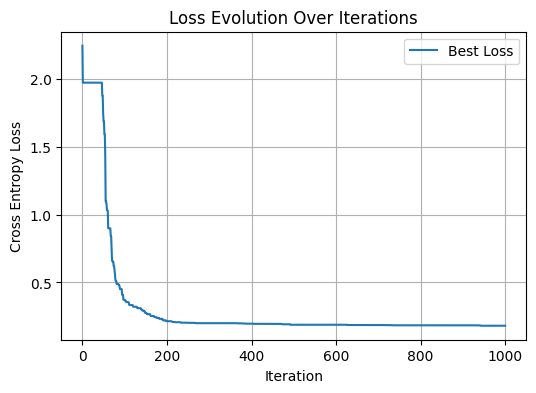

In [18]:
sa1 = SimulatedAnnealing(X_train, y_train, initial_temperature=200, cooling_rate=0.49,iterations=1000, step_size=0.1, penalty = "L1", lambda_term=0.01)
best_weights, loss_history = sa1.optimize()
sa1.predict(X_test)
sa1.evaluate(X_test, y_test)
sa1.plot_loss(loss_history)

Iteration 1000: Best Loss = 0.1355
Best Weights: 
[-0.39536275 -0.22921862 -0.32544372 -0.64969766 -0.21401225 -0.01519495
 -0.43069487 -0.54368731 -0.08072138  0.12387871 -0.36501465  0.0374561
 -0.46146807 -0.56828724 -0.34667493  0.53975436  0.10099567  0.09802329
  0.00725346  0.16605812 -0.47669446 -0.73922529 -0.72027494 -0.42747746
 -0.29906801 -0.13523448 -0.4945784  -0.086101   -0.38416423 -0.31340353]

Best Loss: 0.1355

Evaluation Metrics:
Accuracy:  0.9825
F1 Score:  0.9861
Precision: 0.9726
Recall:    1.0000
ROC AUC:   0.9767


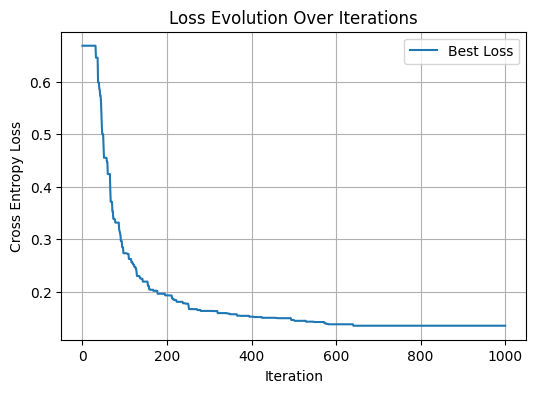

In [19]:
sa1 = SimulatedAnnealing(X_train, y_train, initial_temperature=200, cooling_rate=0.49,iterations=1000, step_size=0.1, penalty = "L2", lambda_term=0.01)
best_weights, loss_history = sa1.optimize()
sa1.predict(X_test)
sa1.evaluate(X_test, y_test)
sa1.plot_loss(loss_history)